In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.neighbors import KernelDensity
import yfinance as yf

sys.path.append('..')
from util.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'AMZN', 'ANET', 'APPH', 'ATVI', 'AXON', 'AYX',
    'BILI', 'BYND', 'COUR','CPNG', 'DDOG', 'DOCU', 'DUOL', 'EDIT', 
    'ETSY', 'FSLY', 'FUV', 'GH', 'GMED', 'GOOG', 'INTG', 'ISRG', 
    'JD', 'LULU', 'LUV', 'MDB', 'MELI', 'MNST', 'MSFT', 'MTCH', 'NVCR', 
    'OKTA', 'PANW', 'PINS', 'PTON', 'QDEL', 'RDFN', 'RGEN', 'ROKU', 'SE', 
    'SHOP', 'SPLK', 'TDOC', 'TEAM', 'TREX', 'TSLA', 'TTD', 'TTWO', 'TWLO', 
    'TWTR', 'UPST', 'VEEV', 'ZEN', 'ZG', 'ZNGA']
INDICES = ['^GSPC', # S&P 500
           '^IXIC', # Nasdaq
           '^NYA']  # NY Stock Exchange (total)
len(SYMBOLS)

58

In [3]:
TODAY = (datetime.now() + timedelta(1)).date()
START = TODAY - timedelta(2*365)
START, TODAY

(datetime.date(2019, 9, 16), datetime.date(2021, 9, 15))

In [4]:
batch = SYMBOLS + INDICES

In [5]:
data = yf.download(batch, start=START, end=TODAY).rename(columns={'Adj Close': 'AdjClose'})

[*********************100%***********************]  61 of 61 completed


In [6]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0]
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    return sub

In [7]:
get_stock_data('DUOL', data)

,AdjClose,Close,High,Low,Open,Volume
Date,,,,,,
2021-07-28,134.255005,134.255005,145.000000,130.000000,141.399994,2887900.0
2021-07-29,134.440002,134.440002,139.000000,132.000000,137.000000,693900.0
2021-07-30,140.250000,140.250000,141.399994,128.500000,135.179993,617700.0
2021-08-02,143.800003,143.800003,147.250000,134.720001,140.000000,586600.0
2021-08-03,139.860001,139.860001,146.990005,138.009995,143.160004,740100.0
2021-08-04,141.500000,141.500000,142.345001,135.899994,136.470001,475900.0
2021-08-05,146.000000,146.000000,152.839996,137.009995,139.009995,724900.0
2021-08-06,134.380005,134.380005,141.860001,132.399994,140.100006,425200.0
2021-08-09,138.250000,138.250000,138.529999,135.000000,135.000000,353700.0


In [8]:
LMB = 0.9

In [9]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    n = stock_data.shape[0]
    WINDOW = min(n, 125)
    stock_data['ann_high'] = (stock_data.Close
                              .rolling(window=WINDOW)
                              .max())
    stock_data['ann_low'] = (stock_data.Close
                             .rolling(window=WINDOW)
                             .min())
    stock_data['drawdown'] = stock_data.Close / stock_data.ann_high
    stock_data['pullup'] = stock_data.Close / stock_data.ann_low
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = ((stock_data.Close 
                            + stock_data.High 
                            + stock_data.Low 
                            + stock_data.Open) 
                           / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.Close / stock_data.est
    stock_data.sort_values('resid', inplace=True)
    stock_data['dev'] = np.array(range(n)) / n
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.Close, label='Close')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.legend();
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.dev)
        plt.axhline(0.5, color='k')
        plt.title(stock)
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(np.sqrt(stock_data.drawdown * stock_data.pullup),
                 color='grey',
                 label='geomean')
        plt.yscale('log')
        plt.legend()
    return (stock_data.resid.tolist()[-1], 
            stock_data.dev.tolist()[-1],
            stock_data.drawdown.tolist()[-1],
            stock_data.pullup.tolist()[-1])

(1.0059833108291358,
 0.45634920634920634,
 0.9245834902254699,
 1.1393696845520154)

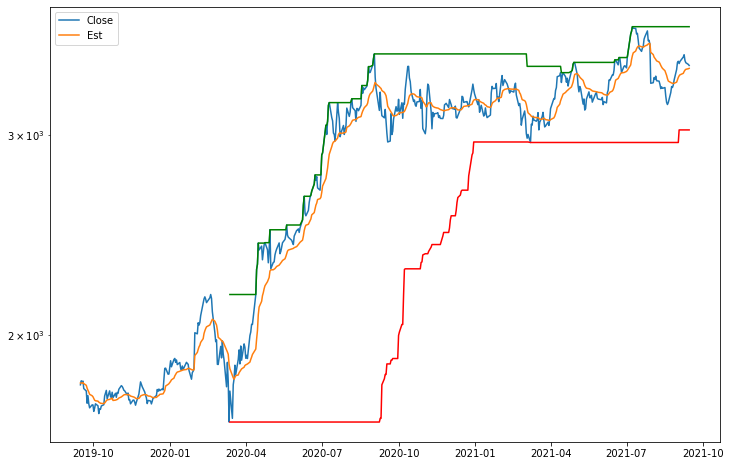

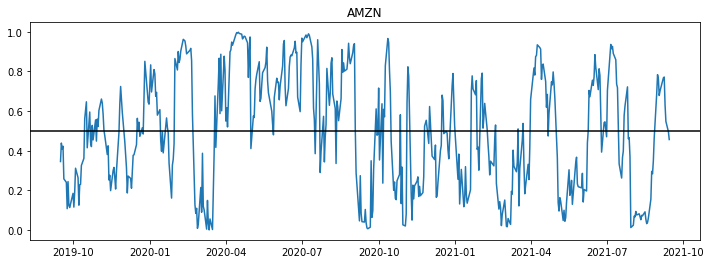

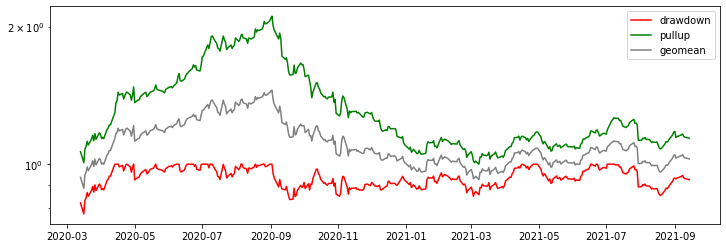

In [11]:
process_stock('AMZN', data.copy(), plot=True)

In [12]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    mult, dev, drop, climb = process_stock(stock, data)
    out.append([stock, mult, dev, drop, climb])

AAPL... ABMD... ABNB... AMZN... ANET... APPH... ATVI... AXON... AYX... BILI... BYND... COUR... CPNG... DDOG... DOCU... DUOL... EDIT... ETSY... FSLY... FUV... GH... GMED... GOOG... INTG... ISRG... JD... LULU... LUV... MDB... MELI... MNST... MSFT... MTCH... NVCR... OKTA... PANW... PINS... PTON... QDEL... RDFN... RGEN... ROKU... SE... SHOP... SPLK... TDOC... TEAM... TREX... TSLA... TTD... TTWO... TWLO... TWTR... UPST... VEEV... ZEN... ZG... ZNGA... ^GSPC... ^IXIC... ^NYA... 

In [13]:
out = pd.DataFrame(data=out, 
                   columns=['stock', 'fair_value_mult', 'dev_quantile', 'drop', 'climb'])
out['geomean'] = np.sqrt(out['drop'] * out.climb)
out.loc
out['score'] = (out.fair_value_mult
                * out.dev_quantile
                * out['drop']
                * out.climb) ** (1/4) 
out.sort_values('score')

,stock,fair_value_mult,dev_quantile,drop,climb,geomean,score
33,NVCR,0.904777,0.083333,0.558870,1.015792,0.753456,0.454851
54,VEEV,0.948740,0.045635,0.876862,1.217170,1.033098,0.463641
6,ATVI,0.964213,0.067460,0.784836,1.000000,0.885909,0.475335
41,ROKU,0.901410,0.087302,0.660605,1.114646,0.858103,0.490632
14,DOCU,0.922254,0.053571,0.864312,1.487456,1.133855,0.502024
...,...,...,...,...,...,...,...
40,RGEN,1.051739,0.684524,0.994596,1.775487,1.328869,1.061855
35,PANW,1.077020,0.900794,1.000000,1.530156,1.236995,1.103815
46,TEAM,1.069558,0.835317,1.000000,1.904760,1.380130,1.142152
28,MDB,1.092652,0.841270,0.995664,2.064272,1.433639,1.172396


In [14]:
out = out.sort_values('stock')
out.to_csv('../data/scoring.csv', index=False)
!open ../data/scoring.csv

In [15]:
try:
    historic = pd.read_csv('../data/historic.csv')
    historic = pd.concat([historic, out])
except FileNotFoundError:
    historic = out
    
print(historic.shape)

(349, 7)


In [16]:
historic = historic[historic.score > 0]
historic.to_csv('../data/historic.csv', index=False)

In [19]:
historic.drop('stock', axis=1).quantile([0.004, 0.01, 0.05, 0.95, 0.99, 0.996])

,fair_value_mult,dev_quantile,drop,climb,geomean,score
0.004,0.892830,0.045635,0.311980,1.000000,0.592877,0.432807
0.010,0.903026,0.049444,0.327742,1.000000,0.601594,0.459070
0.050,0.924944,0.094841,0.599604,1.008160,0.791838,0.523602
0.950,1.077779,0.862857,0.999568,1.974495,1.365249,1.112248
0.990,1.192609,0.918478,1.000000,4.539901,2.073952,1.367015
0.996,1.283631,0.930441,1.000000,4.786262,2.187728,1.540277


In [18]:
1/250

0.004